In [115]:
%matplotlib inline
import numpy as np
import time
import copy
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as transforms
from datetime import datetime 
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.optim import lr_scheduler

In [95]:
import albumentations

from PIL import Image
from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

class ClassificationDataset:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        
        # ImageNet mean and std
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True)
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]
        accelerate_target = targets[2]
        steering_target = targets[0]
        #print(targets)
        if self.resize is not None:
            image = image.resize(
                resize, resample=Image.BILINEAR
            )

        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        #accelerate_target = 

        return {
            "images": torch.tensor(image, dtype=torch.float),
            "accelerate_targets": torch.tensor(accelerate_target, dtype=torch.float),
            "steering_targets": torch.tensor(steering_target, dtype=torch.float)
            #"targets": torch.tensor(targets, dtype=torch.long),
        }

In [125]:
import glob
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
batch_size = 32
resize = (224,224)
DATA_DIR = "/home/gabriel/Área de Trabalho/mk7_dataset"
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))
targets_orig = [eval(x.split("/")[-1][:-4].split("-hash_")[0]) for x in image_files] #list of lists containing the relevant list in the filename for each image

train_images,test_images,train_targets,test_targets = model_selection.train_test_split(
    image_files, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(
    image_paths=train_images,
    targets=train_targets,
    resize=resize
)
# looks like the images are not entering properly and only their paths
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True,
)

test_dataset = ClassificationDataset(
    image_paths=test_images,
    targets=test_targets,
    resize=resize,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False,
)

dataloaders = {
    "train": train_loader,
    "val": test_loader 
}

In [37]:
train_dataset.__getitem__(1)
#TODO: the item is correct with targets, now it must be passed as a batch properly in the train_loader

{'images': tensor([[[-1.4158, -1.4158, -1.4158,  ..., -0.9877, -0.8849, -0.8335],
          [-1.4158, -1.4158, -1.4158,  ..., -0.9877, -0.9020, -0.8335],
          [-1.4158, -1.4158, -1.4158,  ..., -0.9877, -0.9363, -0.9192],
          ...,
          [-0.7308, -0.7137, -0.5938,  ..., -0.3198, -0.4054, -0.5596],
          [-0.6623, -0.5938, -0.4739,  ..., -0.2342, -0.1828, -0.3027],
          [-0.5938, -0.5596, -0.4397,  ..., -0.1999, -0.0972, -0.0629]],
 
         [[ 0.9405,  0.9405,  0.9405,  ...,  1.1506,  1.2206,  1.3081],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.1681,  1.2381,  1.3081],
          [ 0.9405,  0.9405,  0.9405,  ...,  1.1681,  1.2206,  1.2731],
          ...,
          [-0.6176, -0.6001, -0.4776,  ..., -0.1975, -0.2675, -0.4251],
          [-0.5301, -0.4601, -0.3550,  ..., -0.1099, -0.0574, -0.1800],
          [-0.4601, -0.4076, -0.3200,  ..., -0.0574,  0.0476,  0.0651]],
 
         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400

In [138]:
class MK7AutoPilot(nn.Module):

    def __init__(self):
        super().__init__()
        
        #self.backbone = resnet18(pretrained=True)
        self.backbone = resnet18()
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, 10)
        
        # I think it needs 2 Linear layers, one for steering and one for accelerate, then backprop and update them individually
        self.accelerate_fc = nn.Linear(10,1)#nn.Linear(1000, 1)
        self.steering_fc = nn.Linear(10,1)#nn.Linear(1000, 1)
        self.accelerate = nn.Sigmoid()
        self.steering = nn.Tanh()

    def forward(self, inputs):
        x = self.backbone(inputs)
        x_accelerate = self.accelerate_fc(x)
        x_steering = self.steering_fc(x)
        accelerate =  self.accelerate(x_accelerate)
        steering = self.steering(x_steering)
        
        return accelerate, steering

In [139]:
lr=0.001
model = MK7AutoPilot()
device = torch.device('cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)
scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
accelerate_loss = nn.BCELoss() # backprop sigmoid, accelerate in mk7 is just yes or no, no float value :( 
steering_loss = nn.HingeEmbeddingLoss() # backprop tanh (-1 to 1, float represeting the steering from left to right)

In [128]:
# forward pass working
img = torch.rand((1, 3, 224, 224))
acc_, steer_ = model(img)
print(acc_)
print(steer_)

tensor([[0.3454]], grad_fn=<SigmoidBackward>)
tensor([[0.8058]], grad_fn=<TanhBackward>)


In [140]:
num_epoches=100
train_losses = []
val_losses = []

lowest_loss = 50.0
for epoch in range(num_epoches):
    since = time.time()
    print('Epoch {}/{}'.format(epoch, num_epoches - 1))
    print('-' * 10)
    best_model_wts = copy.deepcopy(model.state_dict())
    running_loss = 0.0
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for inputs in dataloaders[phase]:
            # unpack data in train_loader
            batch_images = inputs["images"]
            acc_targets = inputs["accelerate_targets"]
            steer_targets = inputs["steering_targets"]

            # adds dimensions to convert into single row tensor
            acc_targets =  torch.unsqueeze(acc_targets, 1)
            steer_targets =  torch.unsqueeze(steer_targets, 1)

            # insert data in cpu or gpu
            batch_images.to(device)
            acc_targets.to(device)
            steer_targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                #print(phase == 'train')
                acc_out, steer_out = model(batch_images)
                acc_loss = accelerate_loss(acc_out,acc_targets)
                steer_loss = steering_loss(steer_out,steer_targets)
                loss = acc_loss + steer_loss

            if phase== "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item() # batch_size
            
        epoch_loss = running_loss / len(dataloaders[phase]) * batch_size
        
        if phase == "train":
            train_losses.append(epoch_loss)
            scheduler.step()
        else:
            if epoch_loss < lowest_loss:
                lowest_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            val_losses.append(epoch_loss)

        print(f"loss for {phase}: {epoch_loss}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
model.load_state_dict(best_model_wts)
PATH = './mk7-model.pth'
torch.save(model.state_dict(), PATH)

Epoch 0/99
----------
loss for train: 34.39472519723993
loss for val: 333.36067695617675
Epoch 1/99
----------
loss for train: 30.998633535284746
loss for val: 270.1711654663086
Epoch 2/99
----------
loss for train: 30.919327133580257
loss for val: 268.0433490753174
Epoch 3/99
----------
loss for train: 30.473777369449014
loss for val: 263.442094039917
Epoch 4/99
----------
loss for train: 30.490832780536852
loss for val: 269.4311611175537
Epoch 5/99
----------
loss for train: 30.757522432427656
loss for val: 266.5191539764404
Epoch 6/99
----------
loss for train: 30.413146520915785
loss for val: 269.5183307647705
Epoch 7/99
----------
loss for train: 30.68900088260048
loss for val: 265.4566253662109
Epoch 8/99
----------


KeyboardInterrupt: 

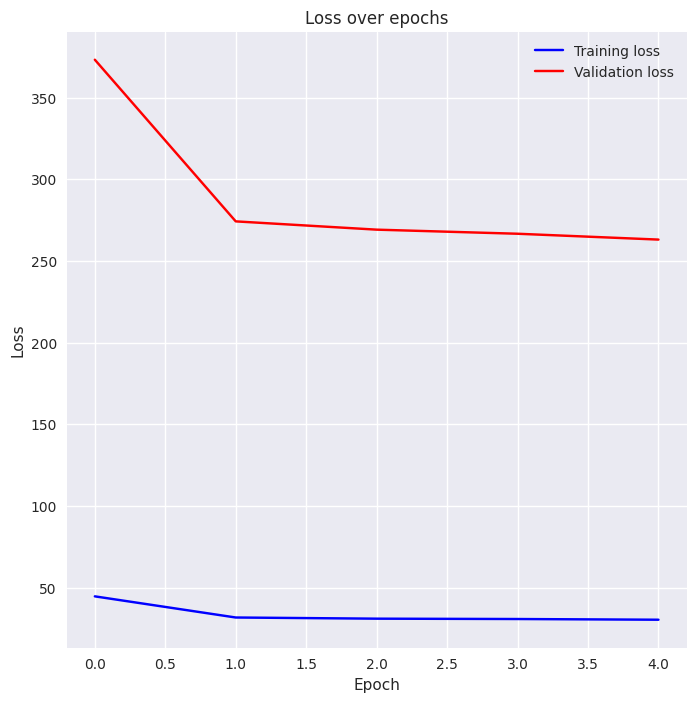

In [112]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losses(train_losses, valid_losses):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    plt.style.use('default')
    plt.show()
    
plot_losses(train_losses, val_losses)

NameError: name 'batch_size' is not defined

In [ ]:
# for epoch in range(epoches):  # loop over the dataset multiple times
#     print(f"\nepoch: {epoch} / {(epoches-1)}")
#     print("----------")
#     for phase in ["train","val"]:
#         if phase == "train":
#             model.train()
#             description="[bold gold3]Training...  [/bold gold3]"
#         else:
#             model.eval()
#             description="[bold blue_violet]Validating...[/bold blue_violet]"
#         running_loss = 0.0
#         running_corrects = 0
#         for inputs,labels in track(dataloaders[phase],description=description):
#             # TODO: pass labels as the list of values, hardcode proper idx as steering and accelerate values
#             # get the inputs; data is a list of [inputs, labels]
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             ## --> forward step
#             # zero the parameter gradients
#             optimizer.zero_grad()

#             with torch.set_grad_enabled(phase == 'train'):
                
#                 outputs = model(inputs)
#                 _, preds= torch.max(outputs,1)
#                 loss = criterion(outputs,labels)# calculates loss its picks the right labels and calculate based on the output predicted
                
#                 # right way for this model i guess
#                 #acc_out, steer_out = model(inputs)
#                 #acc_loss = accelerate_loss(acc_out,acc_target)
#                 #steer_loss = steering_loss(steer_out,steer_target) 
           
#         # --> backward step
#             if phase== "train":
#                 loss.backward()
#                 optimizer.step()
#                 # acc_loss.backward()
#                 # steer_loss.backward()
#                 # optimizer.step()

#             ## --> statistics
#             running_loss += running_loss * inputs.size(0) # batchsize
#             running_corrects += torch.sum(preds==labels.data)# I think preds is a batch of 4 inputs, and we compare the sum of statements that matches the labels.data
            
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc =running_corrects.double()/ dataset_sizes[phase]
            
#         print(f"[bold]Loss[/bold] : {loss:.4f}   [bold]Acc[/bold]: {epoch_acc:.4f}")
#         if phase=="val" and epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())